In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from modules import *
import seaborn as sns

In [27]:
# TODO: evaluieren der korrekten window positionen unter zero indexing, was sind die mindest dinger für die grid search windows, input dataen vollenden (z.B. NAs), die iid bootstraps implementieren

# FIXME: 

# NOTE: NA printout currently disabled for debugging, must be looked into later, evaluate why identical bounds from paper are not robust to all parameter combinations
#cache decorator makes the functions non pickleable -> find
#kann ich meine Ergebnisse eindeutiger machen, wenn ich mehr als 100 Testartikel nehme?

### Testing influence of parameters on window indexes

In [28]:
#sind meine windows centered oder asymmetrisch? -> den zenterpunkt +0.5 setzen

In [29]:
#window size dürfen nur gerade zahlen sein, sonst sind grenzen dezimalzahlen
#dadurch, dass der ub nicht inclusive ist, sind die intervalle nicht symmetrisch um den Index m*b
#was wäre eine Lösung? (abwägung zwischen symmetrischem, ungeraden intervall und asymmetrischem, geraden intervall)
#window size 1 hat die beste performance, dass müssen wir also eigentlich berücksichtigen
#-> wie verhalten sich die intervallgrenzen bei window size 1? mit den decimalzahlengrenzen
N = 313
b = 8
w = 4
M = int(np.ceil(N / b))

# Compute J_1m and J_2m
J_1m_values = np.maximum(0, np.minimum(np.arange(M) * b - w/2-1, N-b - w/2))# Shape: (M,)
print(J_1m_values)

[  0.   5.  13.  21.  29.  37.  45.  53.  61.  69.  77.  85.  93. 101.
 109. 117. 125. 133. 141. 149. 157. 165. 173. 181. 189. 197. 205. 213.
 221. 229. 237. 245. 253. 261. 269. 277. 285. 293. 301. 303.]


[  2.  10.  18.  26.  34.  42.  50.  58.  66.  74.  82.  90.  98. 106.
 114. 122. 130. 138. 146. 154. 162. 170. 178. 186. 194. 202. 210. 218.
 226. 234. 242. 250. 258. 266. 274. 282. 290. 298. 305. 305.]


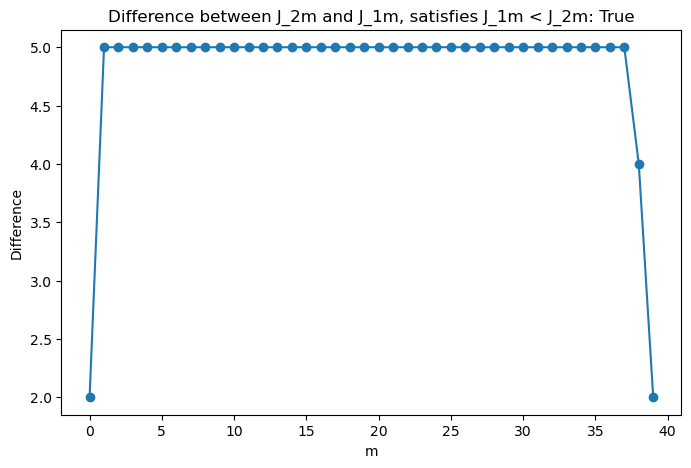

In [30]:

J_2m_values = np.maximum(0, np.minimum(np.arange(M) * b + w/2, N-b))    # Shape: (M,)
print(J_2m_values)

# Compute the difference
difference = J_2m_values - J_1m_values

# Plot the difference
plt.figure(figsize=(8, 5))
plt.plot(range(M), difference, marker='o', linestyle='-', label='J_2m - J_1m')
plt.xlabel('m')
plt.ylabel('Difference')
plt.title(f'Difference between J_2m and J_1m, satisfies J_1m < J_2m: {~np.any(J_1m_values >= J_2m_values)}')
plt.show()

# Metrics
Mathematical formulation for discrete Wasserstein Distance, with $q$ being the quantiles:
$$
W_p(\mu_1, \mu_2) = \left( \int_0^1 \left| F_1^{-1}(q) - F_2^{-1}(q) \right|^p \, dq \right)^{\frac{1}{p}}
$$


In [31]:
GridEvaluation.run(list(InputData.TestData.keys())) #3min auf dem Mac

Batch processing and streaming:   0%|          | 0/20 [00:00<?, ?it/s]

# Error Diagnosis

### 1. Optimierung der Parameter
- **Frage:** Was ist die beste Parameterkombination?

### 2. Identifikation von Ausreißern
- **Frage:** Welche Items sind die größten Ausreißer?

### 3. Bias-Analyse
- **Frage:** Haben wir allgemein einen positiven oder negativen Bias? (Test if correction factor might help)

### 4. Einfluss von Parametern auf Bias und Varianz
- **Frage:** Ändern sich Bias und Varianz mit den Parametern, insbesondere mit der Anzahl der Twins?

### 5. Vergleich mit Bootstrap
- **Frage:** Lohnt sich das im Vergleich zum einfachen Bootstrap?

### 6. Ausblick auf Performance-Änderungen
- **Frage:** Wie ändert sich die Performance, wenn die Beobachtungsperiode um 1 Jahr verschoben wird?
  - **Erwartung:** Der Einfluss des Trends wird erhöht.

In [32]:
df_results = pd.read_csv("results/grid_results.csv")

In [33]:
df_results.head()

,TEST_ITEM_COMMUNICATIONKEY,BLOCK_SIZE,WINDOW_SIZE,TWIN_NUMBER,MEAN_SAMPLE,MEAN_TEST,BIAS,VARIANCE,CV,RMSE,MAPE,MPE,MAE,WASSERSTEIN
0,716679764,1,1,9,981.3482,564.0,417.3482,11393.015960,10.876677,20.755272,73.997908,98034.82,417.3482,426.016006
1,735286989,1,1,7,927.9610,863.0,64.9610,5614.436366,8.074644,9.958332,9.226257,92696.10,79.6226,80.721687
2,796628327,1,1,8,253.9160,138.0,115.9160,512.417427,8.915011,10.867641,83.997101,25291.60,115.9160,116.516968
3,803656013,1,1,10,982.5892,240.0,742.5892,39222.183680,20.155515,27.722638,309.412167,98158.92,742.5892,765.034351
4,804245827,1,1,7,225.1740,145.0,80.1740,986.246973,13.946801,9.279292,55.295724,22417.40,80.1788,82.119556


In [34]:
#1
df_results.groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).median().sort_values("VARIANCE").reset_index()[["WINDOW_SIZE", "BLOCK_SIZE", "VARIANCE" ]].head(20)

,WINDOW_SIZE,BLOCK_SIZE,VARIANCE
0,1,1,3912.648193
1,5,1,4129.127039
2,9,1,4216.344165
3,13,1,4326.158128
4,17,1,4382.228849
5,21,1,4456.865956
6,25,1,4472.036418
7,29,1,4525.447763
8,33,1,4548.401985
9,41,1,4553.649684


In [35]:
df_results.groupby(["WINDOW_SIZE", "BLOCK_SIZE"]).mean().sort_values("WASSERSTEIN").reset_index()[["WINDOW_SIZE", "BLOCK_SIZE", "WASSERSTEIN" ]].head(20)

,WINDOW_SIZE,BLOCK_SIZE,WASSERSTEIN
0,0,1,298.989045
1,25,1,299.665089
2,17,1,299.795087
3,21,1,299.846322
4,13,1,300.221419
5,29,1,300.445890
6,33,1,300.455783
7,37,1,300.556458
8,9,1,300.705154
9,41,1,300.864491


In [36]:
#2 größten ausreißer
df_results.groupby(["TEST_ITEM_COMMUNICATIONKEY"]).mean().sort_values("RMSE", ascending=False).reset_index()[["TEST_ITEM_COMMUNICATIONKEY", "RMSE"]]

,TEST_ITEM_COMMUNICATIONKEY,RMSE
0,829628090,45.719853
1,842058910,42.318870
2,1107699346,37.866348
3,1574713555,37.153498
4,803656013,34.893741
...,...,...
95,856065671,8.582795
96,824014002,8.451542
97,837717257,8.444846
98,1035556462,7.332203


In [37]:
#haben wir eher positiven oder negativ bias?
#verteilungsfunktionen für verschieden gute Parameter Kombinationen plotten

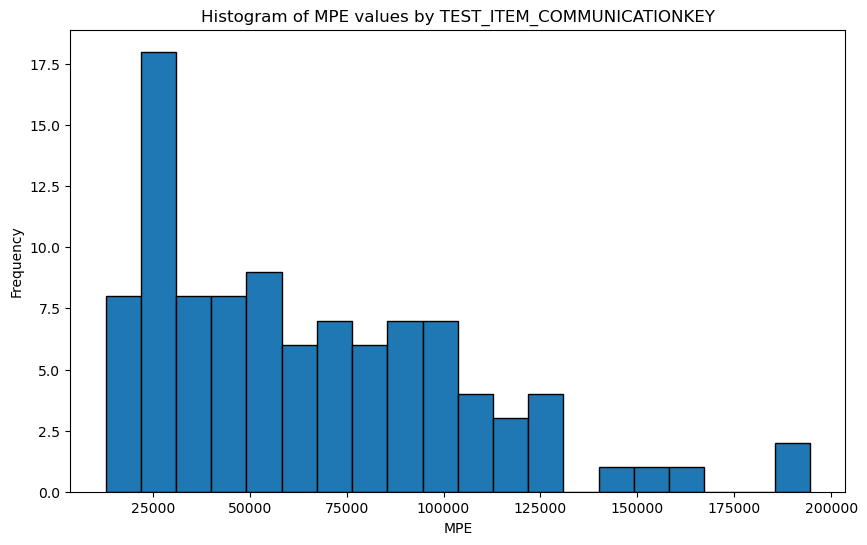

In [38]:
#für den Bias plot: den MPE  als Histogram plotten
# Calculate the aggregated MPE values per TEST_ITEM_COMMUNICATIONKEY
df_hist = df_results.groupby("TEST_ITEM_COMMUNICATIONKEY") \
    .mean() \
    .sort_values("MPE", ascending=False) \
    .reset_index()[["TEST_ITEM_COMMUNICATIONKEY", "MPE"]]

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.hist(df_hist["MPE"], bins=20, edgecolor="black")
plt.xlabel("MPE")
plt.ylabel("Frequency")
plt.title("Histogram of MPE values by TEST_ITEM_COMMUNICATIONKEY")
plt.show()

### Analyse der Ergebnisse

#### Metriken

- **BIAS**:  
- **VARIANCE**: wächst stark durch eine höhere Blocksize  
  → Dadurch direkter Einfluss auf den RMSE
- **MAPE**: ebenfalls best for blocksizes 1
- **MAE**: best for low block sizes, window size influence seems random at first glance

#### Probleme: Vergleichbarkeit

- MAPE statt BIAS
- CV statt VARIANCE  
  → Relative standard deviation, dimensionless, more intuitive to interpret  
  → Wie viel Prozent des Mittelwerts ist die Standardabweichung?

#### Key Erkenntnis

- Die höhere Blocksize ist immer schlecht, während das Window weniger starken Einfluss hat  
  → Die Autokorrelation, welche durch die Blöcke berücksichtigt werden soll, wird in nicht stationärer Zeitreihe nicht deutlich, z.B. wegen Trends
- Trotzdem wird der Basic Bootstrap outperformed von dem LB Bootstrap mit Blocksize 1

#### Offene Fragen

- Wie repräsentativ ist meine Stichprobe?
- Einfluss der Twin Anzahl?
- Einfluss von Median statt Mean?
- Wie wähle ich die beste Parameterkombination aus?  
  → Wie verhalten sich CV und MAPE auf Artikelbasis nach Auswahl der besten Metric?

#### Zukünftiger Fokus

- Zukünftig würde ich mich auch auf **CV, MAPE und WASSERSTEIN** fokussieren


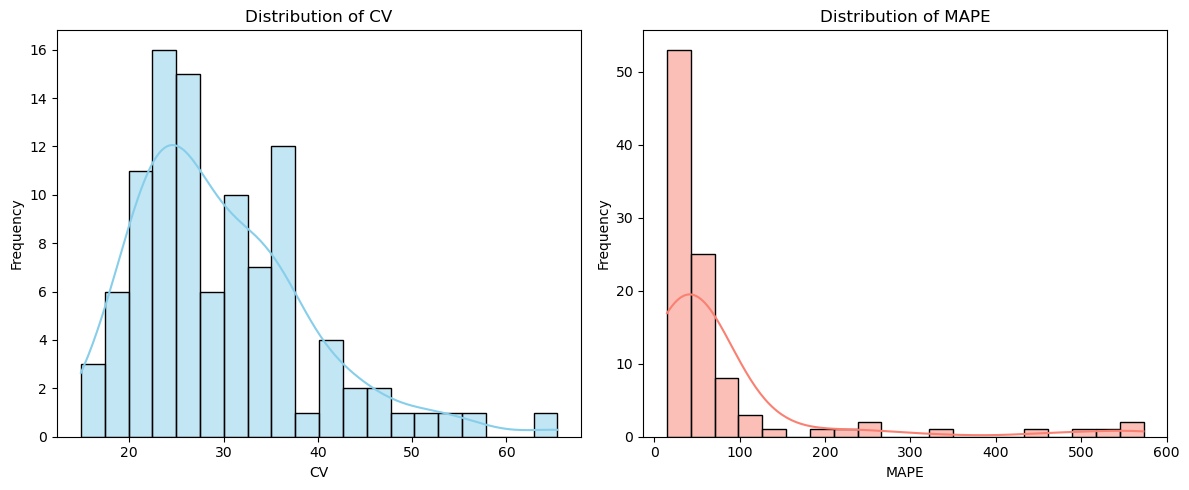

In [39]:
#das jetzt zu plotten ist ein bisschen dumm, weil ich ja die ganzen parameter settings mit den sinnlosen werten habe
df_plot = df_results.groupby(["TEST_ITEM_COMMUNICATIONKEY"]).mean().reset_index()[["TEST_ITEM_COMMUNICATIONKEY", "CV", "MAPE"]]

# Set up the figure with two subplots
plt.figure(figsize=(12, 5))

# Histogram for CV values
plt.subplot(1, 2, 1)
sns.histplot(df_plot['CV'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of CV')
plt.xlabel('CV')
plt.ylabel('Frequency')

# Histogram for MAPE values
plt.subplot(1, 2, 2)
sns.histplot(df_plot['MAPE'], bins=20, kde=True, color='salmon')
plt.title('Distribution of MAPE')
plt.xlabel('MAPE')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Normality test
- clt is defined for iid data
- distributions moments must be finite?
- tune number of iteration until distribution is normal -> helps simplify methods of robust optimization

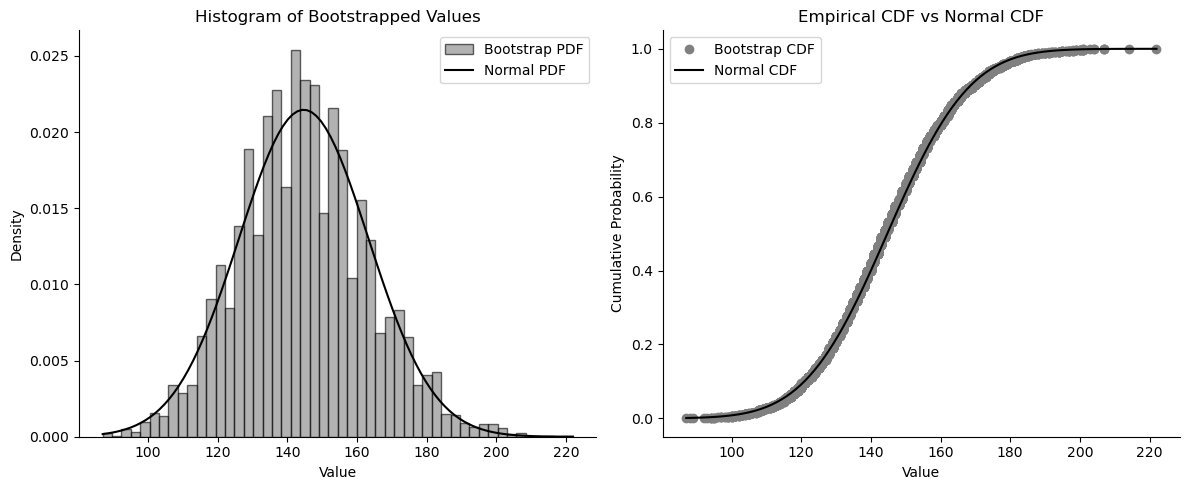

In [40]:
samples = Resampling.lb_bootstrap(InputData.TestData[804245827], 14, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(samples, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(samples), max(samples), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(samples)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(samples), scale=np.sqrt(np.var(samples, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [41]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05

In [42]:
#generate integer samples from normal distribution
norm_samples = np.random.normal(50, 25, 100000).astype(int)

In [43]:
norm_samples = np.random.normal(50, 5, 100000).astype(int)
_, p_value = stats.normaltest(norm_samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does NOT appear to be normally distributed.")

0.4397062652064724
Fail to reject the null hypothesis: The data appears to be normally distributed.


In [44]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(results_simple)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

NameError: name 'results_simple' is not defined